In [0]:
#Using CNN architecture for classification. Using tensorflow and google clab (gpu)

In [4]:
#The below are wrapper functions used to connect to your drive and this needs to be run once (i.e. once every new session or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

# Authentication for your google drive
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()

# Authentication for the wrapper libraries  or possibily refreshes for every 24 hours)

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}


Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18298 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .../0


Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up dirmngr (2.1.15-1ubuntu8) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up python3-gi (3.24.1-2build1) ...
Setting up module-init-tools (24-1ubuntu2) ...
Setting up python3-software-properties (0.96.24.17) ...
Setting up dbus (1.10.22-1ubuntu1) ...
Setting up python-apt (1.4.0~beta3build2) ...
Setting up python3-dbus (1.2.4-1buil

In [5]:
!mkdir -p MyDrive
!google-drive-ocamlfuse MyDrive
% cd MyDrive/Colab-docs/DigitRecognizer

/content/MyDrive/Colab-docs/DigitRecognizer


In [6]:
% pwd

'/content/MyDrive/Colab-docs/DigitRecognizer'

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from __future__ import print_function

In [0]:
# Training Parameters
learning_rate = 0.001
num_steps = 2000
batch_size = 128

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [0]:
#Create a CNN network
def conv_net(x_input, n_classes, dropout, reuse, is_training):
  
  # Define a scope for reusing the variables
  with tf.variable_scope('ConvNet', reuse=reuse):
    #Tenosr input become 4d: [Batch Size, Height, Width, Channel]
    x = tf.reshape(x_input, shape=[-1,28,28,1])
    
    #Convolution layer 1 with 32 filters and kernel size is 5
    conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)
    #Max pooling with strides of 2 and kernel size of 2
    conv1 = tf.layers.max_pooling2d(conv1, 2, 2)

    #Convolution layer 2 with 64 filters and a kernel size of 3
    conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)
    #Max Pooling with strides of 2 and kernel sizes 2
    conv2 = tf.layers.max_pooling2d(conv2, 2, 2)

    #flatten the data to a 1-D vector for fully connected layer
    fc1 = tf.contrib.layers.flatten(conv2)

    #Fully Connected layer
    fc1 = tf.layers.dense(fc1,1024)
    #Apply dropout(if training is false, dropout is not applied)
    fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

    #Output layer class predicition
    out = tf.layers.dense(fc1, n_classes)
  
  return out

In [0]:
#Define the model function (following tf estimator)
def model_fn(features, labels, mode):

  logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
  logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
  
  #Predictions
  pred_classes = tf.argmax(logits_test, axis=1)
  pred_probas = tf.nn.softmax(logits_test)
  
  #If prediction mode, early return
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode, predictions = pred_classes)
  
  #Define loss and optimizer
  loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits_train, labels=tf.cast(labels, dtype=tf.int32) ) )
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
  train_op = optimizer.minimize(loss_op, global_step = tf.train.get_global_step())
  
  acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
  
  # TF Estimators requires to return a EstimatorSpec, that specify
  # the different ops for training, evaluating, ...
  estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

  return estim_specs

In [11]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpk9stbjov', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f33c2d7a978>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [12]:
input_data = pd.read_csv('train.csv')
input_data.shape

(42000, 785)

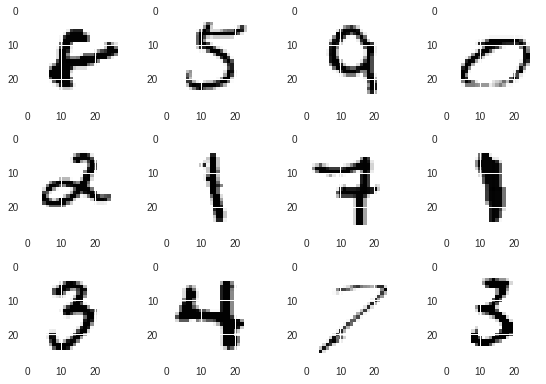

In [13]:
#Viewing the data
c_data = input_data.drop(['label'], axis=1).values

import matplotlib.pyplot as plt
import random

for i in range(0,3):
    for j in range(0,4):
        index = random.randrange(0, len(c_data))
        plot = plt.subplot2grid((3, 4), (i, j))
        plot.imshow(c_data[index].reshape(28,28))

plt.tight_layout()
plt.show()

In [0]:
Y = input_data.label
del input_data['label']
X = input_data

In [15]:
X.shape

(42000, 784)

 ------------- Degree is  0
 ------------- Degree is  -45


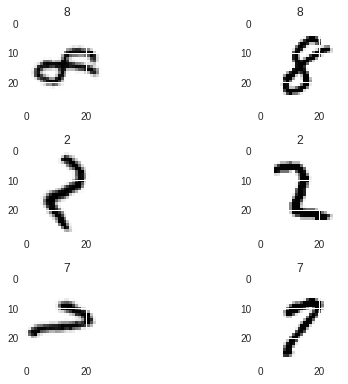

 ------------- Degree is  -23


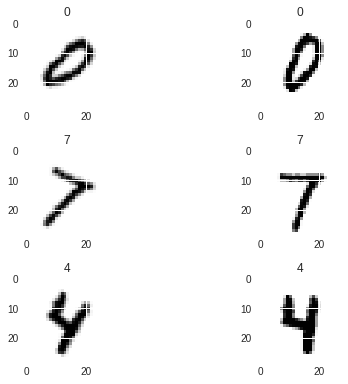

 ------------- Degree is  -20


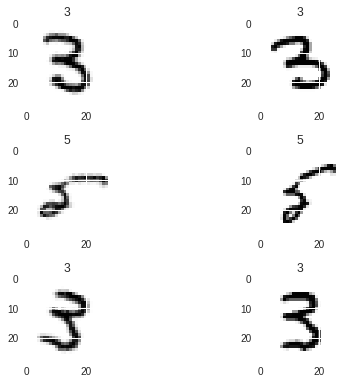

 ------------- Degree is  3


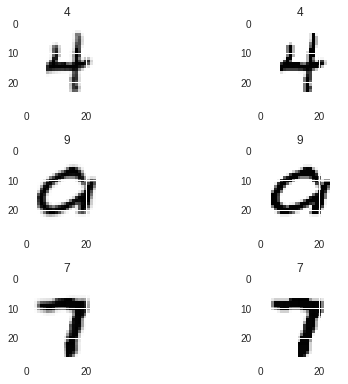

 ------------- Degree is  19


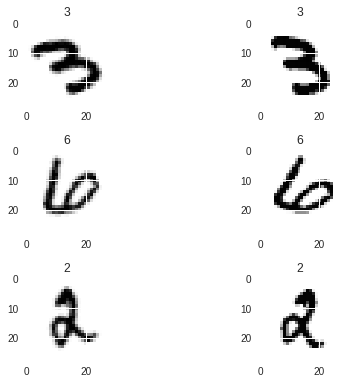

 ------------- Degree is  21


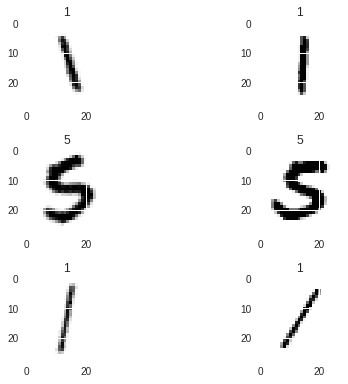

 ------------- Degree is  36


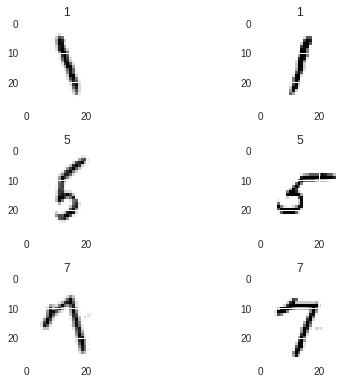

(336000, 28, 28, 1)
(336000,)


In [16]:
import math
IMAGE_SIZE = 28

def plot_rotated(rotated_imgs, actual_imgs, target):
  #print(rotated_imgs.shape)
  #print(actual_imgs.shape)
  
  c_data1 = rotated_imgs
  c_data2 = actual_imgs.values
  t = target.values
  for i in range(0,3):
    for j in range(0,2):
      index = random.randrange(0, len(c_data1))
      ax1 = plot = plt.subplot2grid((3, 2), (i, 0))
      ax1.set_title(t[index])
      plot.imshow(c_data1[index].reshape(28,28))
      ax2 = plot = plt.subplot2grid((3, 2), (i, 1))
      ax2.set_title(t[index])
      plot.imshow(c_data2[index].reshape(28,28))

  plt.tight_layout()
  plt.show()
  
def rotate_images(X_imgs,d1,d2):
  X_rotate = []
  tf.reset_default_graph()
  X = tf.placeholder(tf.float32, shape = (IMAGE_SIZE, IMAGE_SIZE, 1))
  d = tf.placeholder(tf.float32)
  degree = random.randint(d1,d2)
  print(" ------------- Degree is ",degree)
  tf_img = tf.contrib.image.rotate(X, degree * math.pi / 180, interpolation='BILINEAR')
  with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for img in X_imgs:
      img = img.reshape(28,28,1)
      rotated_img = sess.run(tf_img, feed_dict = {X: img})
      X_rotate.append(rotated_img)
        
  X_rotate = np.array(X_rotate, dtype = np.float32)
  return X_rotate

def rotate_all(x,y):
  Augmented_data = rotate_images(x.values,0,0)
  target = y.values
  degrees = [-45, -30, -20, 0, 10, 20, 30, 45]
  for i in range(len(degrees)-1):
    rotated = rotate_images(x.values,degrees[i],degrees[i+1])
    plot_rotated(rotated,x, y)
    Augmented_data = np.concatenate([Augmented_data,rotated])
    target = np.concatenate([target, y])
    
  return Augmented_data, target
  
X1, Y1 = rotate_all(X,Y)

print(X1.shape)
print(Y1.shape)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split( X1, Y1, test_size=0.2, random_state=42)

In [18]:
print(X_train.shape)
print(X_test.shape)

(268800, 28, 28, 1)
(67200, 28, 28, 1)


In [28]:
# Define the input function for training
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.asarray(X_train, dtype=np.float32), y=Y_train,
    batch_size=batch_size, num_epochs=None, shuffle=True)
# Train the Model
model.train(input_fn, steps=num_steps)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk9stbjov/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 8001 into /tmp/tmpk9stbjov/model.ckpt.
INFO:tensorflow:loss = 0.15574735, step = 8000
INFO:tensorflow:global_step/sec: 99.4339
INFO:tensorflow:loss = 0.03225973, step = 8100 (1.010 sec)
INFO:tensorflow:global_step/sec: 121.715
INFO:tensorflow:loss = 0.04074814, step = 8200 (0.823 sec)
INFO:tensorflow:global_step/sec: 122.989
INFO:tensorflow:loss = 0.03986395, step = 8300 (0.814 sec)
INFO:tensorflow:global_step/sec: 121.823
INFO:tensorflow:loss = 0.1566443, step = 8400 (0.818 sec)
INFO:tensorflow:global_step/sec: 121.955
INFO:tensorflow:loss = 0.063240126, step = 8500 (0.820 sec)
INFO:tensorflow:global_step/sec: 120.683
INFO:tensorflow:loss =

In [29]:
# Evaluate the Model
from sklearn.metrics import accuracy_score
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.asarray(X_train, dtype=np.float32), y=Y_train,
    batch_size=batch_size, shuffle=False)

preds = list(model.predict(input_fn))
print(accuracy_score(Y_train, preds))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk9stbjov/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9778608630952381


In [30]:
# Evaluate the Model
from sklearn.metrics import accuracy_score
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.asarray(X_test, dtype=np.float32), y=Y_test,
    batch_size=batch_size, shuffle=False)

preds = list(model.predict(input_fn))
print(accuracy_score(Y_test, preds))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk9stbjov/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
0.9749404761904762


In [31]:
test_data = pd.read_csv('test.csv')
test_data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
test_data.shape

(28000, 784)

In [47]:
# Get images from test set
c_data = test_data.values
test_images = c_data
# Prepare the input data
input_fn = tf.estimator.inputs.numpy_input_fn(
    x=np.asarray(test_images, dtype=np.float32), shuffle=False)
# Use the model to predict the images class
preds = model.predict(input_fn)
p = list(preds)
print(len(c_data))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpk9stbjov/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
28000


28000


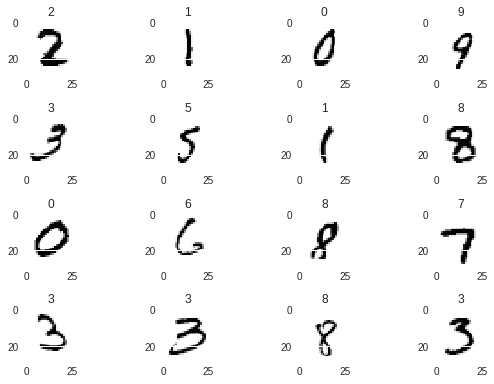

In [53]:
print(len(p))
a = 4
b = 4
for i in range(0,a):
    for j in range(0,b):
        index = random.randrange(0, len(c_data))
        plot = plt.subplot2grid((a, b), (i, j))
        plot.set_title(p[index])
        plot.imshow(test_images[index].reshape(28,28))
        
plt.tight_layout()
plt.show()

In [55]:
type(p)

list

In [72]:
#result = np.asarray(p)
df = pd.DataFrame({'ImageId': list(range(1,28001)), 'Label': p })
df.to_csv('result_cnn_augmented.csv',index=False)
df.head()

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
